# Hugging Face Diffusers

In this notebook, we run through an example of generating MNIST digits using the Hugging Face `diffusers` library. As we will see, we will be able to produce high quality digits using only a CPU.

In [20]:
from datasets import load_dataset
import torch
from diffusers import UNet2DModel

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

In [21]:
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=(8, 16, 32),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    num_class_embeds=10,
    norm_num_groups=1,
)

In [22]:
model

UNet2DModel(
  (conv_in): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=8, out_features=32, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=32, out_features=32, bias=True)
  )
  (class_embedding): Embedding(10, 32)
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(1, 8, eps=1e-05, affine=True)
          (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=32, out_features=8, bias=True)
          (norm2): GroupNorm(1, 8, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): 

In [23]:
# transform to min-max normalize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / x.max())
])
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 

In [24]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=200) 

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [26]:
from diffusers.optimization import get_cosine_schedule_with_warmup

num_train_steps = len(train_loader) * 10
print(num_train_steps)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=(num_train_steps),
)

18750


In [27]:
from tqdm import tqdm

for epoch in range(10):
    model.train()
    for i, (clean_images, labels) in tqdm(enumerate(train_loader)):
        noise = torch.randn(clean_images.shape)
        bs = clean_images.shape[0]
        labels = labels

        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps, labels, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    
    print(f'Epoch {epoch} Loss: {loss.item()}')


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
1875it [03:42,  8.43it/s]


Epoch 0 Loss: 0.04561576619744301


1875it [03:27,  9.02it/s]


Epoch 1 Loss: 0.04327964410185814


1875it [03:29,  8.96it/s]


Epoch 2 Loss: 0.04432613030076027


1875it [03:28,  9.00it/s]


Epoch 3 Loss: 0.033934012055397034


1875it [03:30,  8.92it/s]


Epoch 4 Loss: 0.03634652495384216


1875it [03:28,  8.97it/s]


Epoch 5 Loss: 0.03282684087753296


1875it [03:24,  9.19it/s]


Epoch 6 Loss: 0.030779113993048668


1875it [03:24,  9.16it/s]


Epoch 7 Loss: 0.03889871761202812


1875it [03:23,  9.20it/s]


Epoch 8 Loss: 0.031148657202720642


1875it [03:41,  8.48it/s]

Epoch 9 Loss: 0.03246668353676796


In [28]:
import numpy as np

In [29]:
type(torch.manual_seed(42))

torch._C.Generator

In [47]:
def inference(model: UNet2DModel,
              scheduler: DDPMScheduler,
              batch_size: int,
              generator: torch._C.Generator,
              num_inference_steps: int,
              label: int) -> np.ndarray:
    
    image_shape = (batch_size, 1, 28, 28)
    # if label is a list
    if isinstance(label, list):
        labels = torch.tensor(label)
    else:
        labels = torch.full((batch_size,), label)

    image = torch.randn(image_shape)

    # set step values
    scheduler.set_timesteps(num_inference_steps)

    for t in scheduler.timesteps:
        # 1. predict noise model_output
        model_output = model(image, t, labels).sample

        # 2. compute previous image: x_t -> x_t-1
        image = scheduler.step(model_output, t, image, generator=generator).prev_sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.permute(0, 2, 3, 1)

    return image.detach().numpy()

In [52]:
images = inference(model=model,
                   scheduler=noise_scheduler,
                   batch_size=10,
                   generator=torch.manual_seed(1337),
                   num_inference_steps=200,
                   label=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [49]:
images.shape

(10, 28, 28, 1)

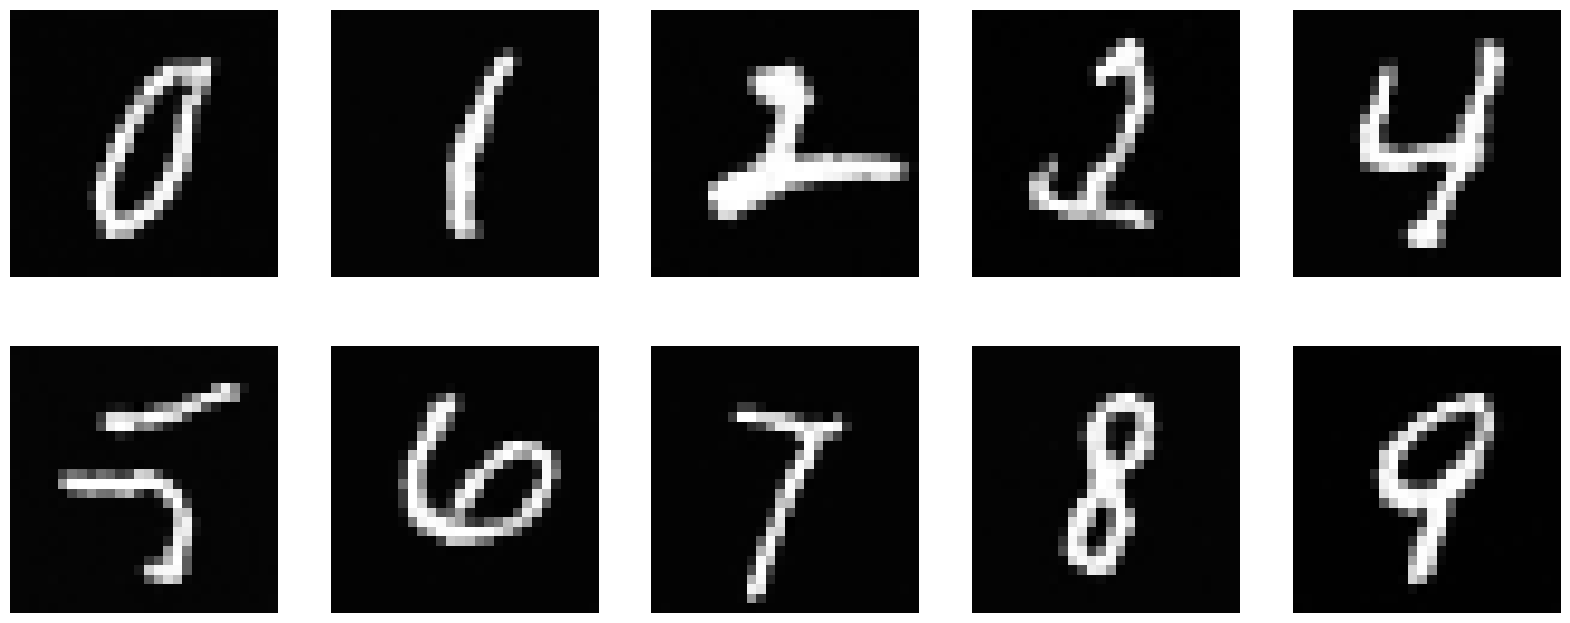

In [53]:
# show images
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(images[i], cmap='gray')
    ax[i // 5, i % 5].axis('off')